# RNN Framework for Graph Node Degree Prediction

This notebook implements a Recurrent Neural Network (RNN) framework that predicts node degrees based on node types in a graph. The input consists of pathways generated by a random walker traversing the graph.

In [42]:
# Import required libraries
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Dict, Tuple

## 1. Graph Data Structure Setup

We'll create a graph structure using NetworkX with node type and degree annotations. We'll define helper functions for graph manipulation.

In [43]:
class GraphManager:
    def __init__(self, num_nodes: int = 100, node_types: List[str] = ['A', 'B', 'C']):
        self.G = nx.Graph()
        self.node_types = node_types
        self.create_random_graph(num_nodes)
    
    def create_random_graph(self, num_nodes: int):
        # Create nodes with random types
        for i in range(num_nodes):
            node_type = random.choice(self.node_types)
            self.G.add_node(i, type=node_type)
        
        # Create random edges (Erdős-Rényi model)
        p = 0.1  # probability of edge creation
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if random.random() < p:
                    self.G.add_edge(i, j)
        
        # Update node degrees
        for node in self.G.nodes():
            self.G.nodes[node]['degree'] = self.G.degree[node]
    
    def create_hierarchical_graph(self, num_nodes: int):
        """Create a graph where nodes of type A have higher degree than B, and B higher than C."""
        # Clear existing graph
        self.G.clear()
        
        # Create nodes with balanced types
        nodes_per_type = num_nodes // 3
        for i in range(num_nodes):
            if i < nodes_per_type:
                node_type = 'A'
            elif i < 2 * nodes_per_type:
                node_type = 'B'
            else:
                node_type = 'C'
            self.G.add_node(i, type=node_type)
        
        # Create edges with different probabilities based on node types
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                type_i = self.G.nodes[i]['type']
                type_j = self.G.nodes[j]['type']
                
                # Set edge probability based on node types
                if type_i == 'A' and type_j == 'A':
                    p = 0.3  # High connectivity between A nodes
                elif type_i == 'C' and type_j == 'C':
                    p = 0.05  # Low connectivity between C nodes
                elif type_i == 'B' and type_j == 'B':
                    p = 0.15  # Medium connectivity between B nodes
                elif 'A' in (type_i, type_j):
                    p = 0.2  # Medium-high connectivity when one node is A
                elif 'B' in (type_i, type_j):
                    p = 0.1  # Medium-low connectivity when one node is B
                else:
                    p = 0.05  # Low connectivity for remaining cases
                
                if random.random() < p:
                    self.G.add_edge(i, j)
        
        # Update node degrees
        for node in self.G.nodes():
            self.G.nodes[node]['degree'] = self.G.degree[node]
    
    def get_node_info(self, node: int) -> Tuple[str, int]:
        """Return node type and degree for a given node."""
        return self.G.nodes[node]['type'], self.G.nodes[node]['degree']
    
    def get_node_neighbors(self, node: int) -> List[int]:
        """Return list of neighboring nodes."""
        return list(self.G.neighbors(node))

# Create a sample hierarchical graph
graph = GraphManager(num_nodes=100)
graph.create_hierarchical_graph(100)

# Print average degrees by node type
degrees_by_type = {'A': [], 'B': [], 'C': []}
for node in graph.G.nodes():
    node_type = graph.G.nodes[node]['type']
    degree = graph.G.degree[node]
    degrees_by_type[node_type].append(degree)

print("Average degrees by node type:")
for node_type in ['A', 'B', 'C']:
    avg_degree = sum(degrees_by_type[node_type]) / len(degrees_by_type[node_type])
    print(f"Type {node_type}: {avg_degree:.2f}")

Average degrees by node type:
Type A: 22.97
Type B: 14.12
Type C: 11.82


## 2. Random Walker Implementation

We'll implement a random walk algorithm to generate pathways through the graph, collecting node types and degrees along the way.

In [44]:
class RandomWalker:
    def __init__(self, graph_manager: GraphManager, walk_length: int = 20):  # Increased from 10 to 20
        self.graph = graph_manager
        self.walk_length = walk_length
    
    def generate_walk(self, start_node: int = None) -> List[Tuple[str, int]]:
        """Generate a random walk and return list of (node_type, degree) tuples."""
        if start_node is None:
            start_node = random.choice(list(self.graph.G.nodes()))
        
        walk = []
        current_node = start_node
        
        for _ in range(self.walk_length):
            # Get current node's type and degree
            node_type, node_degree = self.graph.get_node_info(current_node)
            walk.append((node_type, node_degree))
            
            # Get neighbors and select next node
            neighbors = self.graph.get_node_neighbors(current_node)
            if not neighbors:
                break
            current_node = random.choice(neighbors)
        
        return walk
    
    def generate_walks(self, num_walks: int) -> List[List[Tuple[str, int]]]:
        """Generate multiple random walks."""
        walks = []
        for _ in range(num_walks):
            walks.append(self.generate_walk())
        return walks

# Create a walker and generate some sample walks
walker = RandomWalker(graph)
sample_walks = walker.generate_walks(num_walks=5)
print("Sample walk:", sample_walks[0])

Sample walk: [('B', 17), ('A', 30), ('B', 21), ('B', 19), ('C', 13), ('B', 19), ('B', 14), ('B', 17), ('C', 8), ('B', 19), ('A', 15), ('A', 28), ('A', 27), ('C', 13), ('A', 27), ('A', 22), ('A', 26), ('B', 12), ('A', 26), ('B', 21)]


## 3. Node Feature Encoding

We'll create encoders for node types and implement feature extraction from walk paths.

In [45]:
class FeatureEncoder:
    def __init__(self, node_types: List[str]):
        self.node_types = node_types
        self.type_to_idx = {t: i for i, t in enumerate(node_types)}
        self.num_types = len(node_types)
    
    def encode_node_type(self, node_type: str) -> torch.Tensor:
        """Convert node type to one-hot encoded tensor."""
        idx = self.type_to_idx[node_type]
        one_hot = torch.zeros(self.num_types)
        one_hot[idx] = 1
        return one_hot
    
    def encode_walk(self, walk: List[Tuple[str, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Convert a walk to tensor of features (node types) and labels (degrees)."""
        features = torch.stack([self.encode_node_type(node_type) for node_type, _ in walk])
        labels = torch.tensor([degree for _, degree in walk], dtype=torch.float32)
        return features, labels

# Create encoder and encode sample walks
encoder = FeatureEncoder(graph.node_types)
features, labels = encoder.encode_walk(sample_walks[0])
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: torch.Size([20, 3])
Labels shape: torch.Size([20])


## 4. RNN Model Architecture

We'll define the RNN model using PyTorch, including LSTM layers and fully connected layers for degree prediction.

In [46]:
class GraphRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, num_layers: int = 3):  # Increased complexity
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer to learn better node type representations
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
        # Bidirectional LSTM to capture patterns in both directions
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Fully connected layers with skip connection
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # *2 for bidirectional
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Initial embedding
        x = self.embedding(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Pass through fully connected layers with skip connections
        out = self.dropout(lstm_out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out.squeeze(-1)

# Create model instance
model = GraphRNN(input_size=len(graph.node_types))
print("Model created successfully")

Model created successfully


## 5. Training Data Generation

We'll create a custom dataset for our graph walks and set up data loaders for training.

In [47]:
class GraphWalkDataset(Dataset):
    def __init__(self, walks: List[List[Tuple[str, int]]], encoder: FeatureEncoder):
        self.walks = walks
        self.encoder = encoder
        
    def __len__(self) -> int:
        return len(self.walks)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        walk = self.walks[idx]
        return self.encoder.encode_walk(walk)

# Generate more training data
num_walks = 5000  # Increased from 1000
walks = walker.generate_walks(num_walks)
dataset = GraphWalkDataset(walks, encoder)

# Create data loader with smaller batch size
batch_size = 16  # Decreased from 32 for better generalization
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Created dataset with {len(dataset)} walks")
# Sample batch
for batch_features, batch_labels in dataloader:
    print("Sample batch shapes:", batch_features.shape, batch_labels.shape)
    break

Created dataset with 5000 walks
Sample batch shapes: torch.Size([16, 20, 3]) torch.Size([16, 20])


## 6. Model Training Loop

We'll implement the training loop with loss calculation, backpropagation, and optimization steps.

Epoch [10/100], Loss: 13.6085
Epoch [20/100], Loss: 12.6495
Epoch [20/100], Loss: 12.6495
Epoch [30/100], Loss: 12.5796
Epoch [30/100], Loss: 12.5796
Epoch [40/100], Loss: 12.4789
Epoch [40/100], Loss: 12.4789
Epoch [50/100], Loss: 12.3142
Epoch [50/100], Loss: 12.3142
Epoch [60/100], Loss: 11.8778
Epoch [60/100], Loss: 11.8778
Epoch [70/100], Loss: 11.1117
Epoch [70/100], Loss: 11.1117
Epoch [80/100], Loss: 10.0546
Epoch [80/100], Loss: 10.0546
Epoch [90/100], Loss: 9.0718
Epoch [90/100], Loss: 9.0718
Epoch [100/100], Loss: 8.1042
Epoch [100/100], Loss: 8.1042


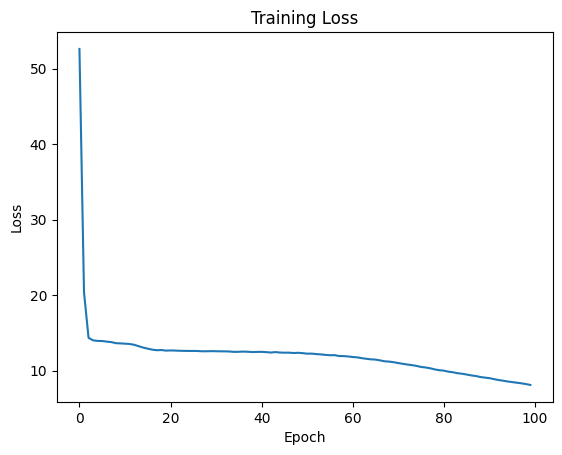

In [48]:
def train_model(model: nn.Module, 
             dataloader: DataLoader,
             num_epochs: int = 100,
             learning_rate: float = 0.001) -> List[float]:
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_features, batch_labels in dataloader:
            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return losses

# Train the model
losses = train_model(model, dataloader)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 7. Prediction and Evaluation

Let's test our model on new paths and evaluate its performance.

In [49]:
def evaluate_model(model: nn.Module, walker: RandomWalker, encoder: FeatureEncoder, num_test_walks: int = 100):
    model.eval()
    test_walks = walker.generate_walks(num_test_walks)
    total_mse = 0.0
    
    with torch.no_grad():
        for walk in test_walks:
            features, true_degrees = encoder.encode_walk(walk)
            features = features.unsqueeze(0)  # Add batch dimension
            predicted_degrees = model(features).squeeze(0)
            mse = ((predicted_degrees - true_degrees) ** 2).mean().item()
            total_mse += mse
    
    avg_mse = total_mse / num_test_walks
    return avg_mse

# Evaluate the model
test_mse = evaluate_model(model, walker, encoder)
print(f"Test MSE: {test_mse:.4f}")

# Make predictions on a sample walk
sample_walk = walker.generate_walk()
features, true_degrees = encoder.encode_walk(sample_walk)
features = features.unsqueeze(0)

model.eval()
with torch.no_grad():
    predicted_degrees = model(features).squeeze(0)

# Compare predictions with true values
print("\nSample Predictions vs True Values:")
for i, (pred, true) in enumerate(zip(predicted_degrees, true_degrees)):
    node_type = sample_walk[i][0]
    print(f"Node {i} (Type {node_type}): Predicted degree: {pred:.1f}, True degree: {true:.0f}")

Test MSE: 17.6363

Sample Predictions vs True Values:
Node 0 (Type C): Predicted degree: 12.3, True degree: 13
Node 1 (Type A): Predicted degree: 22.8, True degree: 23
Node 2 (Type A): Predicted degree: 20.6, True degree: 25
Node 3 (Type C): Predicted degree: 11.2, True degree: 16
Node 4 (Type A): Predicted degree: 17.7, True degree: 25
Node 5 (Type B): Predicted degree: 13.9, True degree: 13
Node 6 (Type A): Predicted degree: 17.7, True degree: 25
Node 7 (Type B): Predicted degree: 14.2, True degree: 9
Node 8 (Type B): Predicted degree: 15.8, True degree: 12
Node 9 (Type C): Predicted degree: 12.7, True degree: 10
Node 10 (Type B): Predicted degree: 15.4, True degree: 12
Node 11 (Type C): Predicted degree: 11.0, True degree: 10
Node 12 (Type B): Predicted degree: 13.8, True degree: 12
Node 13 (Type C): Predicted degree: 12.6, True degree: 9
Node 14 (Type C): Predicted degree: 10.4, True degree: 11
Node 15 (Type A): Predicted degree: 18.9, True degree: 21
Node 16 (Type A): Predicted de